In [1]:
!pwd

/home/sebastian.khan/git/stk/ml/waveforms/jun2022/m2


In [2]:
import wispy.model_utils

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16})

In [5]:
def plot_loghist(x, bins, axvlines=None):
    """
    https://stackoverflow.com/questions/47850202/plotting-a-histogram-on-a-log-scale-with-matplotlib
    """
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.figure(figsize=(14, 6))
    plt.hist(x, bins=logbins, histtype='step', linewidth=4)
    plt.xscale('log')
    # plt.xlabel('mismatch')
    if axvlines is not None:
        for axvline in axvlines:
            plt.axvline(axvline, c='k')

In [6]:
# wispy.model_utils.load_history("")

In [7]:
import pandas as pd

In [8]:
import tensorflow as tf

2022-07-08 12:13:22.220476: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-08 12:13:22.220520: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [9]:
import corner_plot

In [10]:
import model_utils

In [12]:
model = tf.keras.models.load_model("data_spin_saved_model.h5")

2022-07-08 12:13:26.373501: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-08 12:13:26.373537: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-08 12:13:26.373562: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ldas-pcdev5): /proc/driver/nvidia/version does not exist
2022-07-08 12:13:26.373816: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 time_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 theta_input (InputLayer)       [(None, 9)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          256         ['time_input[0][0]']             
                                                                                                  
 dense_1 (Dense)                (None, 128)          1280        ['theta_input[0][0]']            
                                                                                              

In [14]:
# don't do this unless you take care of loading large datasets
print("load training data")
train_thetas = np.load("data_spin/train/theta.npy")
# train_times = np.load("data_spin/train/times.npy")
# train_hps = np.load("data_spin/train/hps.npy")

print("load validation data")
val_thetas = np.load("data_spin/val/theta.npy")
val_times = np.load("data_spin/val/times.npy")
val_hps = np.load("data_spin/val/hps.npy")

load training data
load validation data


In [15]:
val_thetas.shape

(100, 9)

In [16]:
val_times.shape

(4140, 1)

In [17]:
val_hps.shape

(100, 4140)

In [18]:
val_thetas[0]

array([ 3.        , -0.21062428, -0.16407157, -0.80215585,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

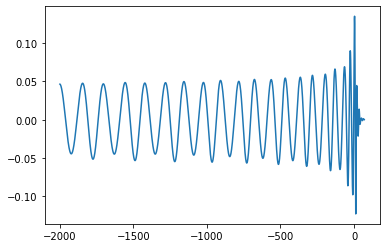

In [19]:
plt.plot(val_times, val_hps[0])

In [20]:
X = np.column_stack((val_times, (np.ones_like(val_times) * val_thetas[0])))

In [21]:
yhat = model([X[:,0], X[:,1:]])

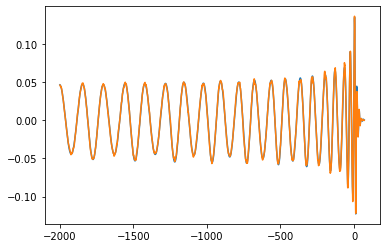

In [22]:
plt.plot(val_times, val_hps[0])
plt.plot(val_times, yhat)

(-100.0, 100.0)

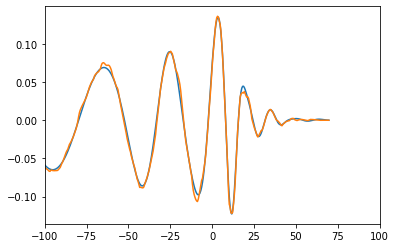

In [23]:
plt.plot(val_times, val_hps[0])
plt.plot(val_times, yhat)
plt.xlim(-100, 100)

# compute mse over validation set

In [24]:
def build_input_single(t, *args):
    """
    t is a matrix i.e. shape = (-1, 1)
    list of parameters
    """
    theta = np.array([*args])
    theta = np.ones_like(t) * theta

    return np.column_stack((t, theta))

In [25]:
def build_input_multiple(t, thetas):
    """
    t is a vector
    thetas is a vector
    """
    return np.row_stack([build_input_single(t, *theta) for theta in thetas])

In [26]:
X_val = build_input_multiple(val_times, val_thetas)

In [27]:
X_val.shape

(414000, 10)

In [28]:
%%time
yhat_val = model([X_val[:,0], X_val[:,1:]])

CPU times: user 7.72 s, sys: 20.6 s, total: 28.3 s
Wall time: 2.48 s


In [29]:
n_waveforms = val_thetas.shape[0]
n_times = val_times.shape[0]

In [30]:
yhat_val = yhat_val.numpy().reshape(n_waveforms, n_times)

In [31]:
val_thetas.shape

(100, 9)

In [32]:
yhat_val.shape

(100, 4140)

In [33]:
mses = tf.keras.losses.mse(yhat_val, val_hps).numpy()

In [34]:
tf.math.reduce_mean(mses)

<tf.Tensor: shape=(), dtype=float64, numpy=3.28049154056919e-06>

In [35]:
mses.shape

(100,)

In [36]:
plt.figure()
plt.plot(mses, 'o')

In [37]:
plot_loghist(mses, 20)

Text(0, 0.5, 'spin1y')

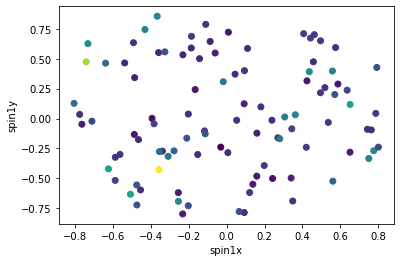

In [44]:
plt.figure()
plt.scatter(val_thetas[:,1], val_thetas[:,2], c=mses)
plt.xlabel('spin1x')
plt.ylabel('spin1y')

plt.figure()
plt.scatter(val_thetas[:,1], val_thetas[:,3], c=mses)
plt.xlabel('spin1x')
plt.ylabel('spin1y')

Text(0, 0.5, 'spin1y')

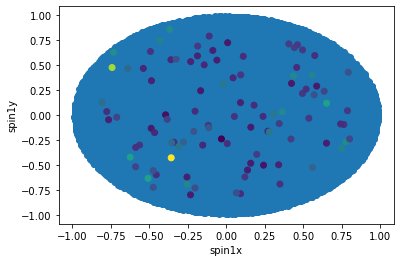

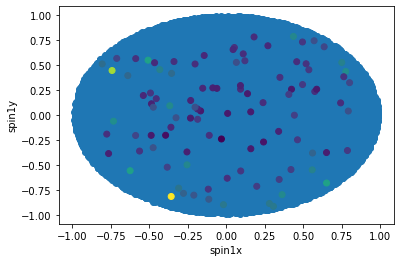

In [45]:
plt.figure()
plt.scatter(train_thetas[:,1], train_thetas[:,2])
plt.scatter(val_thetas[:,1], val_thetas[:,2], c=mses)
plt.xlabel('spin1x')
plt.ylabel('spin1y')

plt.figure()
plt.scatter(train_thetas[:,1], train_thetas[:,3])
plt.scatter(val_thetas[:,1], val_thetas[:,3], c=mses)
plt.xlabel('spin1x')
plt.ylabel('spin1y')

In [46]:
worst_idx = mses.argmax()
worst_idx

11

In [47]:
val_thetas[worst_idx]

array([ 3.        , -0.35777633, -0.42781193, -0.81530793,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

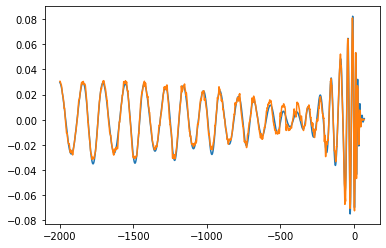

In [48]:
plt.plot(val_times, val_hps[worst_idx])
plt.plot(val_times, yhat_val[worst_idx])

(-100.0, 100.0)

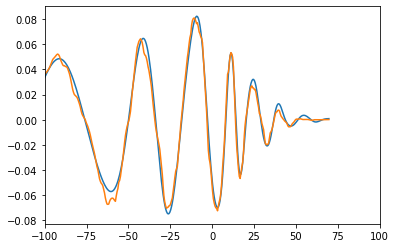

In [49]:
plt.plot(val_times, val_hps[worst_idx])
plt.plot(val_times, yhat_val[worst_idx])
plt.xlim(-100, 100)

In [50]:
df_mse = pd.DataFrame({'mse':mses})

In [51]:
df_mse = df_mse.sort_values(by='mse', ascending=False)

In [52]:
df_mse.index

Int64Index([11, 61, 67, 32, 33, 40,  9, 88, 25, 62, 42, 94, 59, 77, 81,  4, 55,
            97, 66, 76, 44, 89, 68, 18,  0, 39, 58, 48, 52, 78, 71, 82, 56, 87,
            16, 90, 38, 54, 60, 37, 93,  1, 72, 96, 24,  3, 85, 10, 35, 15, 50,
            49, 20, 43, 34, 64, 74, 75, 80, 45, 63, 47, 19,  8, 84, 91, 36, 22,
            14, 70, 73, 51, 92, 99, 28, 13, 69, 46,  6, 79, 23, 30, 86, 17, 12,
            27,  5, 65, 53, 95, 57, 83, 98, 29,  7, 26, 31, 21,  2, 41],
           dtype='int64')

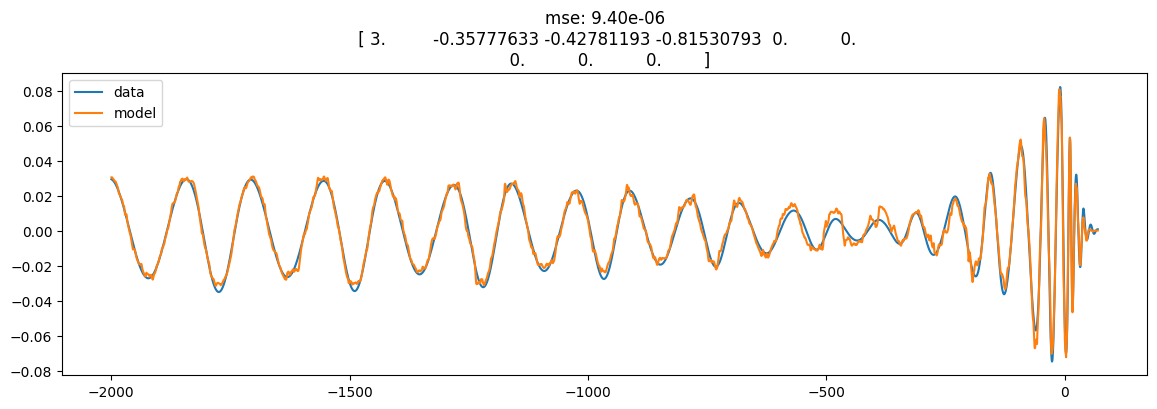

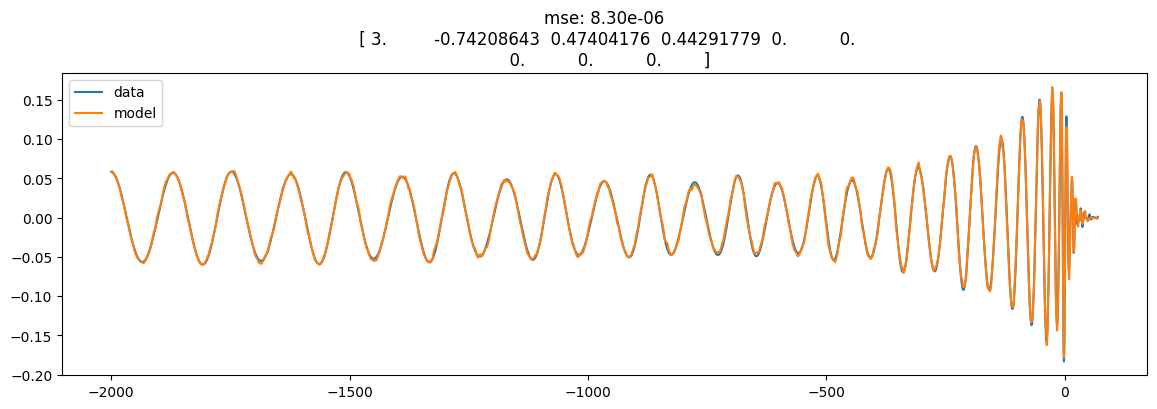

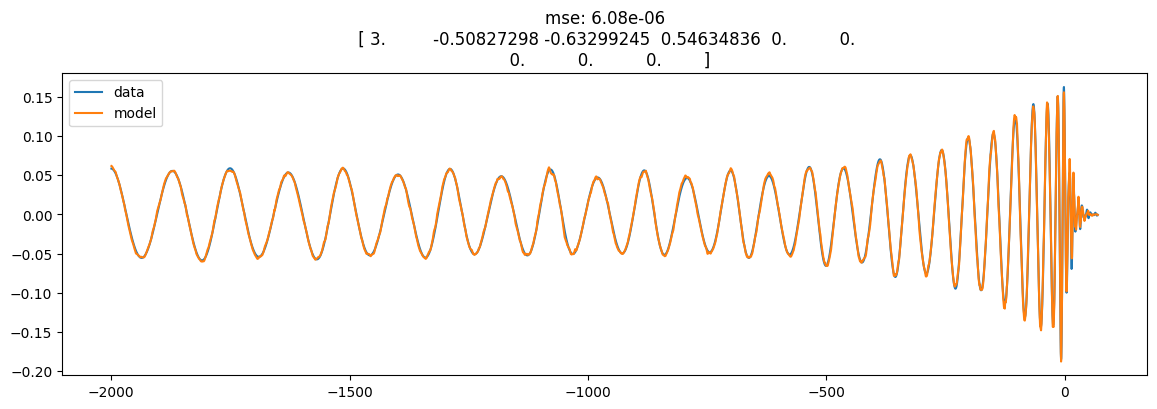

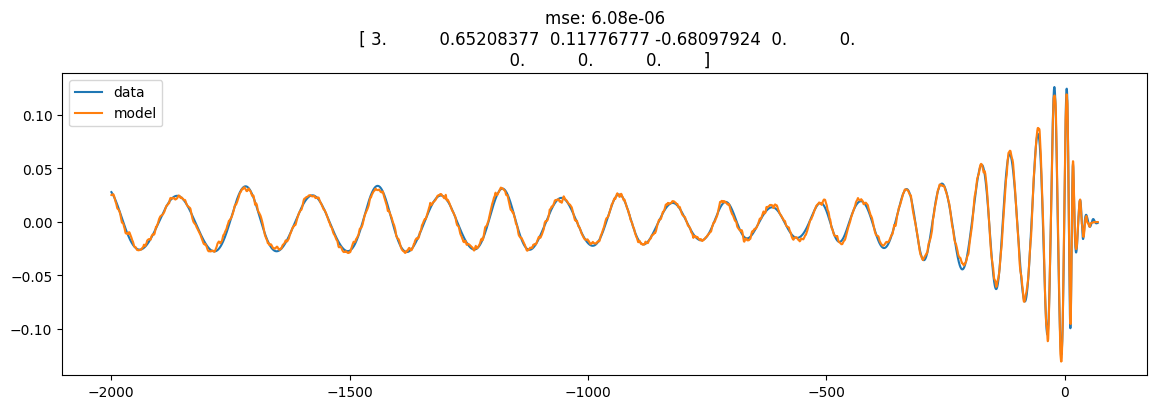

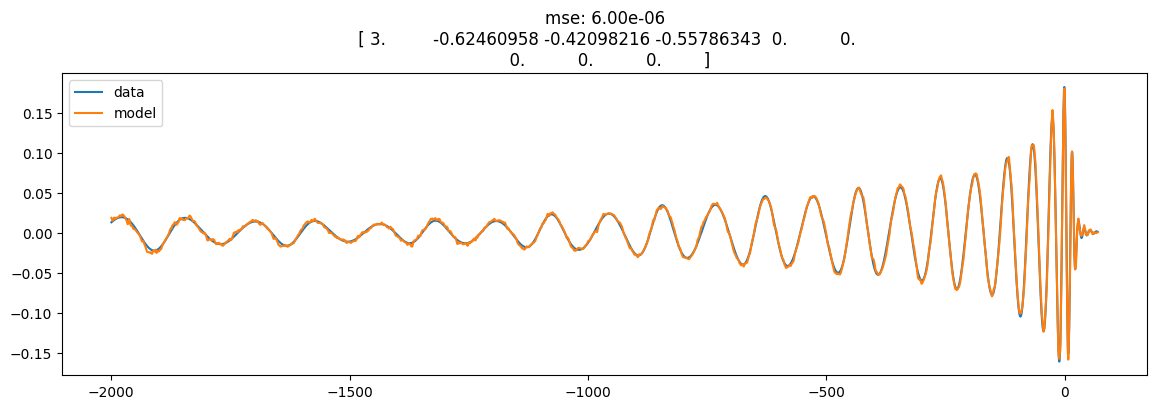

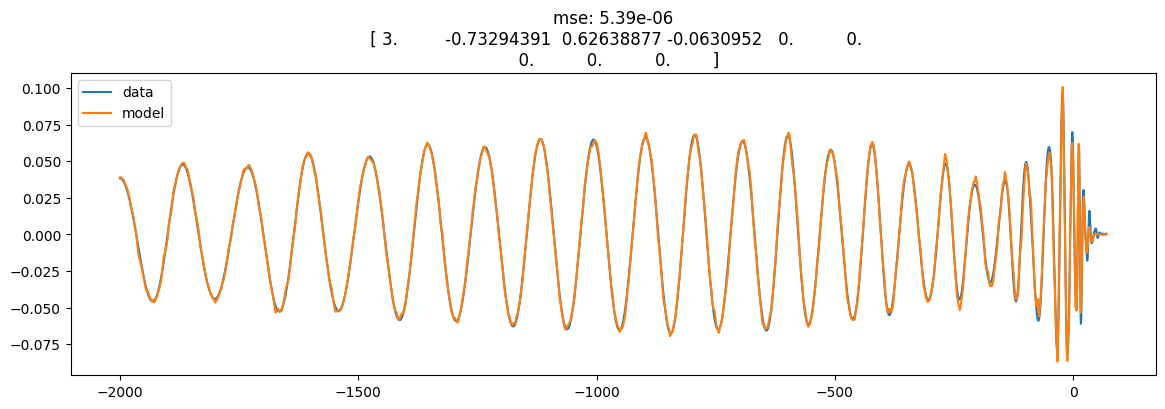

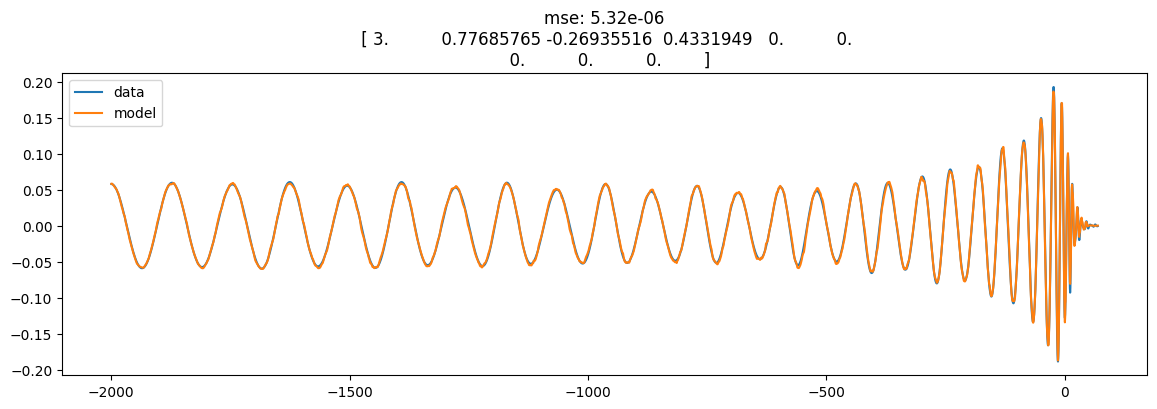

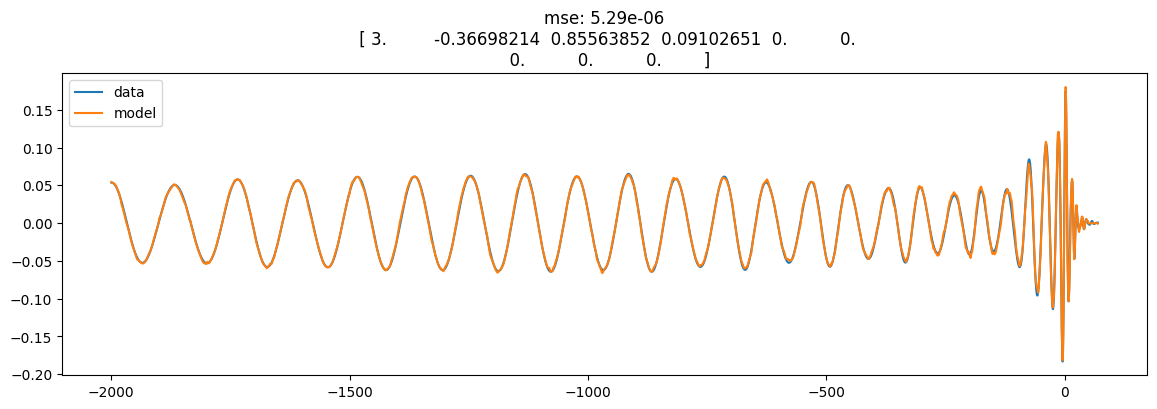

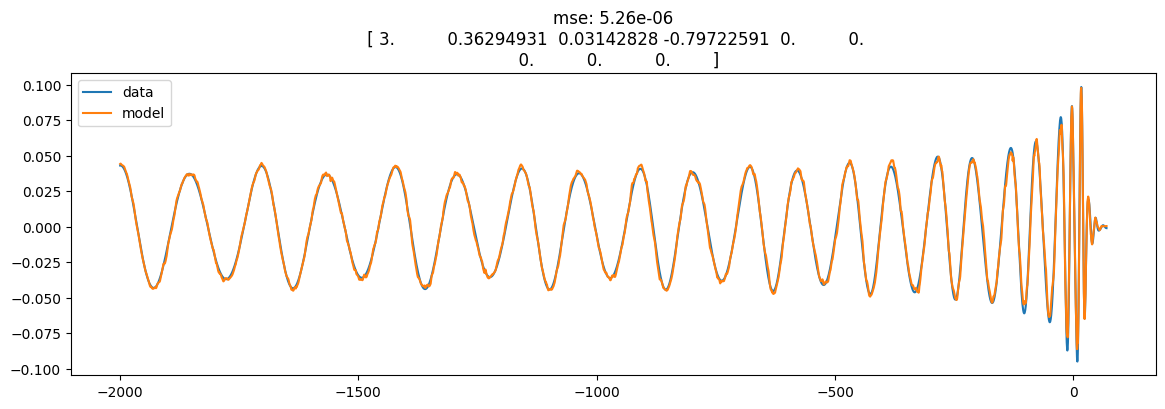

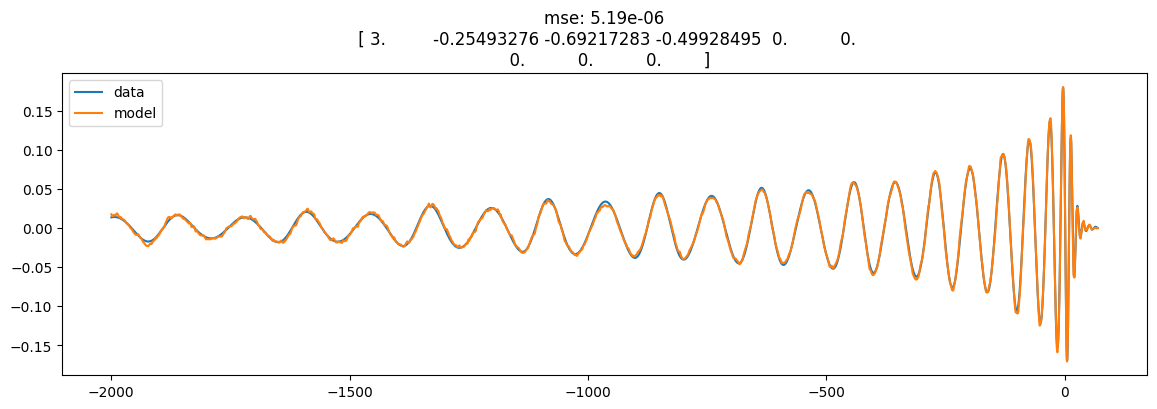

In [54]:
for i in df_mse.index[:10]:
    plt.figure(figsize=(14, 4), dpi=100)
    plt.plot(val_times, val_hps[i], label='data')
    plt.plot(val_times, yhat_val[i], label='model')
    # plt.xlim(-100, 100)
    plt.title(f"mse: {df_mse.loc[i].values[0]:.2e}\n {val_thetas[i]}")
    plt.legend()
    plt.show()
    plt.close()

# compute matches

In [55]:
import waveform

In [56]:
from pycbc.types import TimeSeries
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower

In [57]:
val_hps[0].dtype

dtype('float64')

In [58]:
yhat_val[0].dtype

dtype('float32')

In [59]:
def compute_match(h1, h2, times, total_mass):

    f_low = 30

    dt = times[1] - times[0]
    dt = waveform.MtoS(dt, total_mass)
    h1 = TimeSeries(h1.astype("double"), delta_t=dt)
    h2 = TimeSeries(h2.astype("double"), delta_t=dt)
    
    # # Resize the waveforms to the same length
    tlen = max(len(h1), len(h2))
    h1.resize(tlen)
    h2.resize(tlen)

    # Generate the aLIGO ZDHP PSD
    delta_f = 1.0 / h1.duration
    flen = tlen//2 + 1
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

    # Note: This takes a while the first time as an FFT plan is generated
    # subsequent calls are much faster.
    m, _ = match(h1, h2, psd=psd, low_frequency_cutoff=f_low)
    
    return m

In [60]:
compute_match(val_hps[0], yhat_val[0], val_times[:,0], 100)

0.993302701116847

In [61]:
%%time
all_matches = []
for i in range(len(val_hps)):
    m = compute_match(val_hps[i], yhat_val[i], val_times[:,0], 100)
    all_matches.append(m)
all_matches = np.array(all_matches)

CPU times: user 1min 17s, sys: 165 ms, total: 1min 17s
Wall time: 5.56 s


In [62]:
pd.DataFrame({'matches':all_matches}).describe()

matches
count  100.000000
mean     0.996308
std      0.004084
min      0.976039
25%      0.995982
50%      0.997759
75%      0.998382
max      0.998963

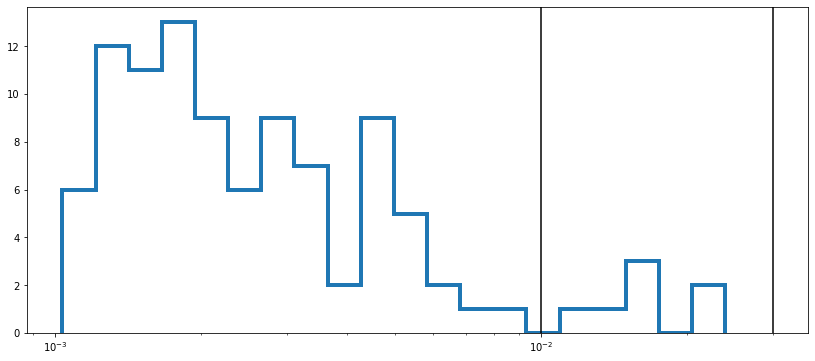

In [63]:
plot_loghist(1-all_matches, 20, axvlines=[1-0.97, 1-0.99])

# model prediction as a function of inclination

In [460]:
val_thetas[0,7]

5.773056812284071

In [461]:
def gen_Xs(times, mass_ratio=1, coa_phase=0, npts=10):
    thetas = np.zeros(shape=(npts, 9))
    thetas[:,0] = mass_ratio
    
    
    thetas[:,7] = coa_phase
    incs = np.linspace(0, np.pi, npts)
    for i in range(len(thetas)):
        thetas[i,8] = incs[i]
    

    
    
    X = build_input_multiple(times, thetas)
    return X

In [462]:
npts=10

In [463]:
new_times = np.arange(-2000, 70, 0.25)[:,np.newaxis]

In [464]:
newX = gen_Xs(new_times, mass_ratio=2, coa_phase=0, npts=npts)

In [465]:
newX.shape

(82800, 10)

In [466]:
%%time
newY = model([newX[:,0], newX[:,1:]])

CPU times: user 2.95 s, sys: 5.46 s, total: 8.41 s
Wall time: 584 ms


In [467]:
newY = newY.numpy().reshape(npts, new_times.shape[0])

In [468]:
newY.shape

(10, 8280)

In [469]:
plt.figure(figsize=(20, 4), dpi=100)
for yy in newY:
    plt.plot(new_times, yy)
# plt.xlim(-100, 100)

In [470]:
%%time
test_times, test_thetas, test_hps, test_hcs = waveform.generate_waveforms_mp(
    new_times[:,0],
    mass_ratios=np.array([2]*npts),
    spin1xs=np.array([0]*npts),
    spin1ys=np.array([0]*npts),
    spin1zs=np.array([0]*npts),
    spin2xs=np.array([0]*npts),
    spin2ys=np.array([0]*npts),
    spin2zs=np.array([0]*npts),
    coa_phases=np.array([0]*npts),
    inclinations=np.linspace(0, np.pi, npts),
    time_idxs=None,
    total_mass=100,
    approximant="IMRPhenomXP",
    distance_mpc=1,
    delta_t=1/4096,
    f_lower=10,
    nproc=1,
)

CPU times: user 18.9 ms, sys: 92.4 ms, total: 111 ms
Wall time: 694 ms


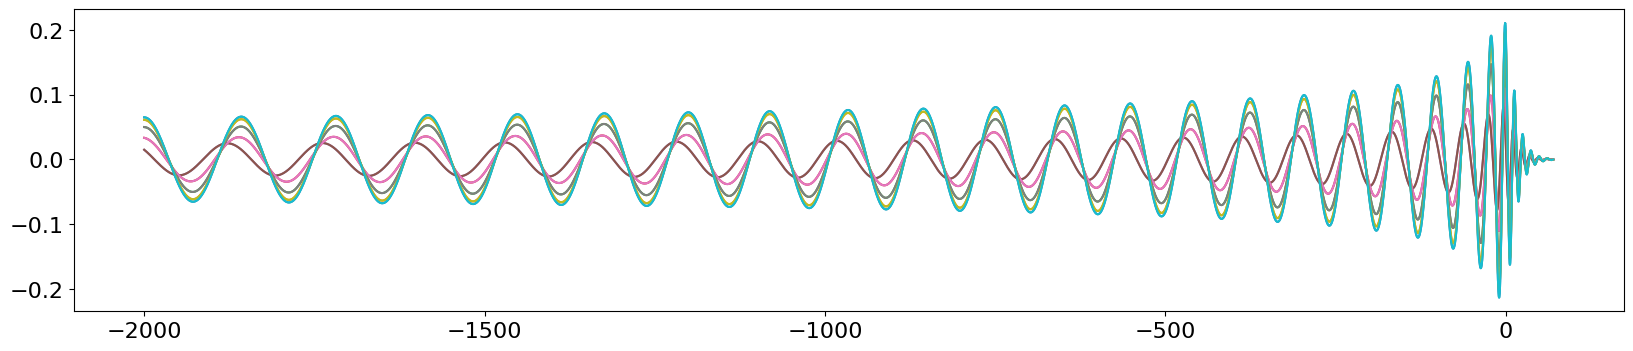

In [471]:
plt.figure(figsize=(20, 4), dpi=100)
for test_hp in test_hps:
    plt.plot(new_times, test_hp)
# plt.xlim(-100, 100)

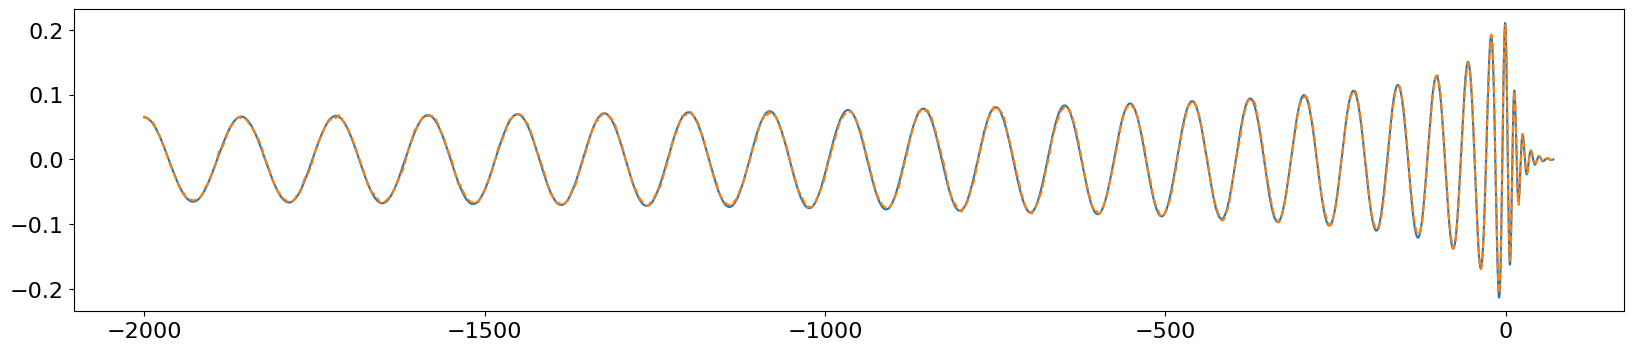

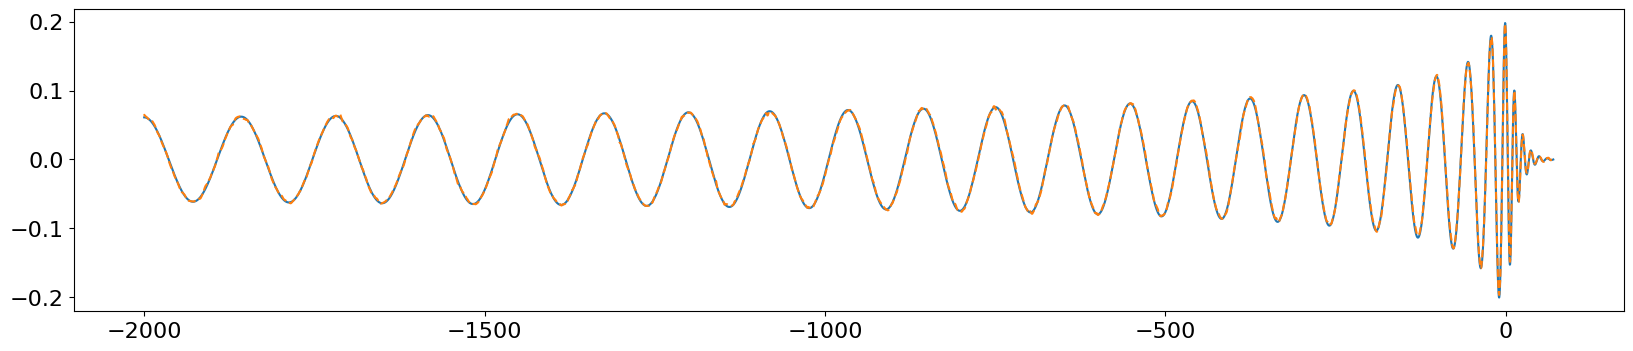

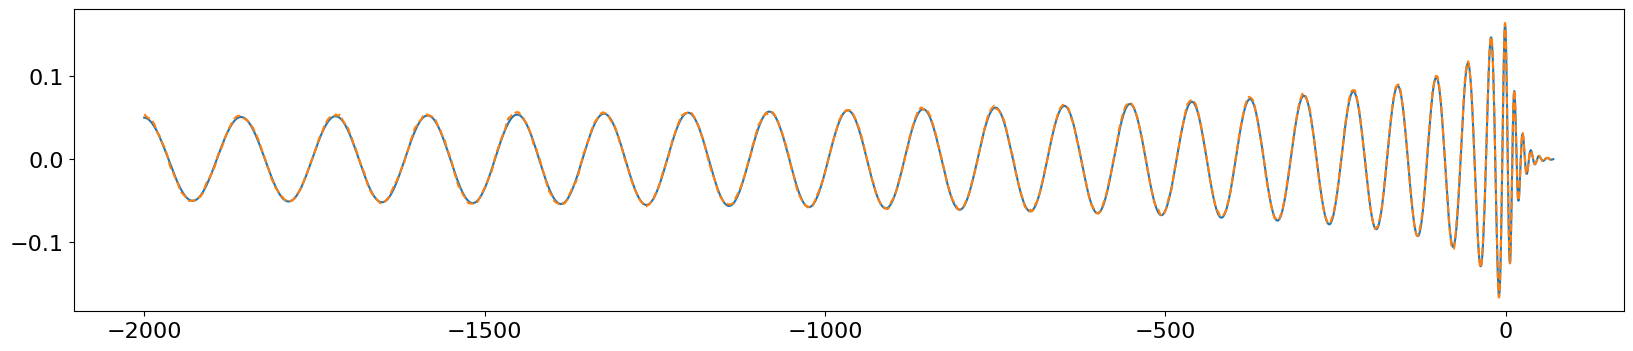

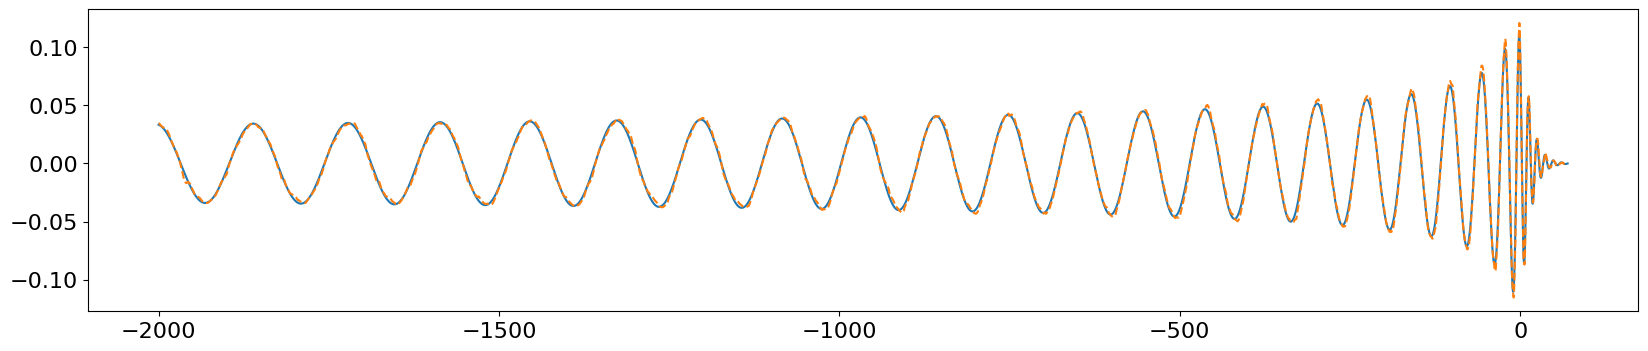

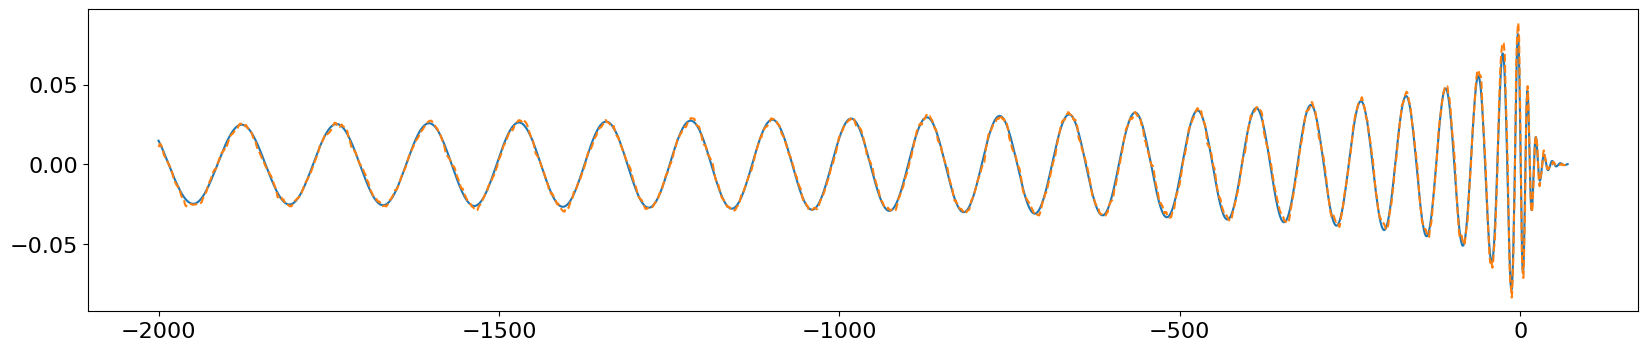

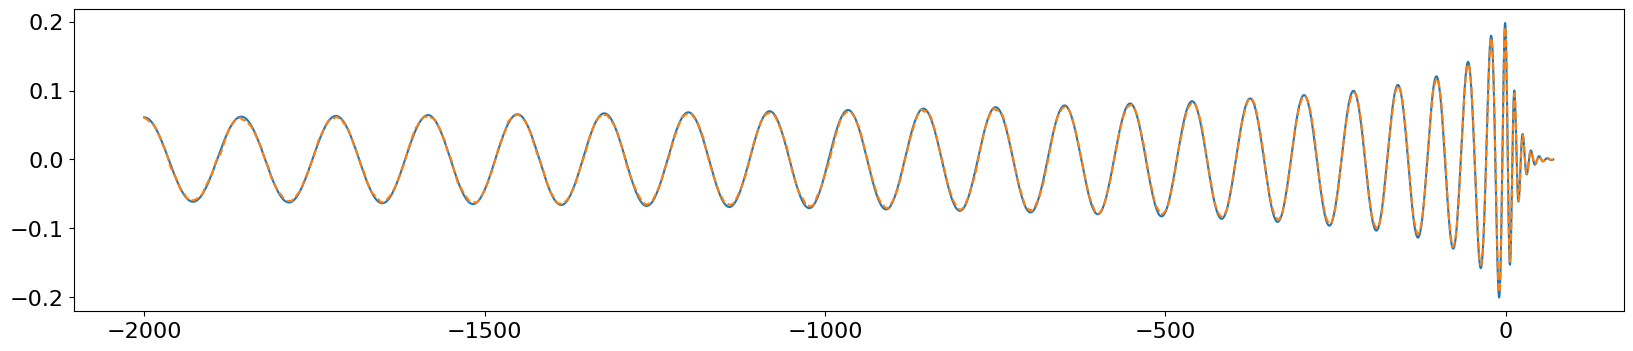

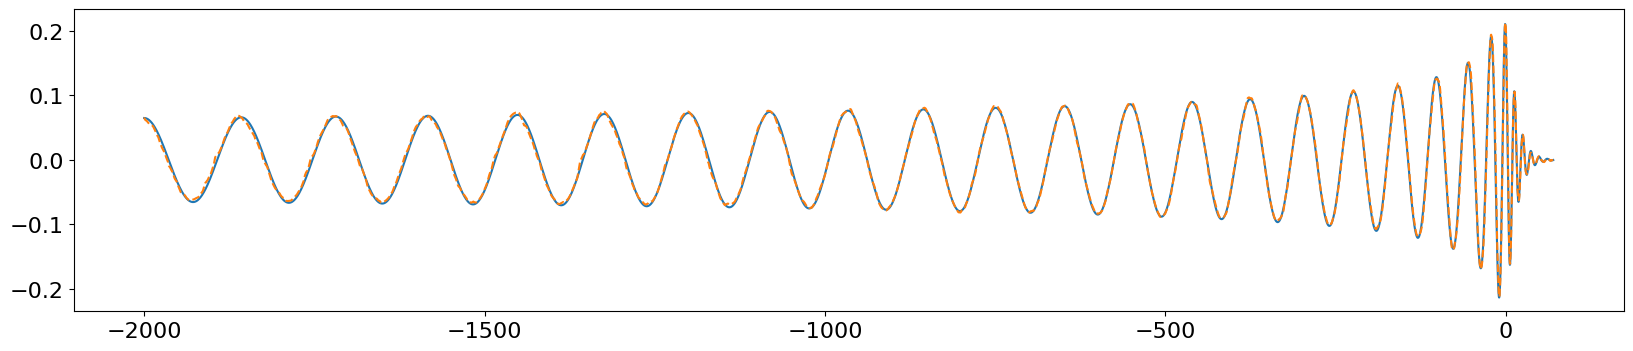

In [472]:
for i in range(npts):
    plt.figure(figsize=(20, 4), dpi=100)
    plt.plot(new_times, test_hps[i])
    plt.plot(new_times, newY[i], ls='--')
    # plt.xlim(-100, 100)